In [1]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
import eli5

In [2]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# train_pred = pd.read_csv('./simple_xgboost_cv.csv', index_col='TransactionID')
# test_pred = pd.read_csv('./simple_xgboost_pred.csv', index_col='TransactionID')
# test_pred['pred'] = (test_pred['pred1'] + test_pred['pred2'] + test_pred['pred3'] )/3
# del test_pred['pred1'],test_pred['pred2'],test_pred['pred3']

# train_f2 = pd.read_csv('../input/f2_train.csv', index_col='TransactionID')
# del train_f2['isFraud']
# test_f2 = pd.read_csv('../input/f2_test.csv', index_col='TransactionID')

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

CPU times: user 48.7 s, sys: 4.78 s, total: 53.4 s
Wall time: 53.4 s


In [3]:
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)

In [4]:
train_test = train_transaction.append(test_transaction)
for col in "card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
    s = set(train_transaction[col].tolist())
#     print(col,test_transaction[col].map(lambda x:0 if x in s else 1).sum())


for col in "card1,card2,card5,addr1,addr2".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
    col_count1 = train_test[train_test['C5'] == 0].groupby(col)['C5'].count()
    col_count2 = train_test[train_test['C5'] != 0].groupby(col)['C5'].count()
    train_transaction[col+'_C5count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
    test_transaction[col+'_C5count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
    
for col in "card1,card2,addr1".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].std()
    train_transaction[col+'_Amtstdcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_Amtstdcount'] = test_transaction[col].map(col_count)
    
#     print(col,len(set(train_transaction[col].tolist())),len(set(test_transaction[col].tolist())),len(set(test_transaction[col].tolist()) - set(train_transaction[col].tolist())))

# for col in "C3,C4,C5,C7,C8,C9,C10,C12".split(","):
#     print(train_transaction[col].value_counts())
#     col_count1 = train_test[train_test[col] == 0].groupby("card1")[col].count()
#     col_count2 = train_test[train_test[col] != 0].groupby("card1")[col].count()
#     train_transaction["card1"+'_'+ col +'count'] = train_transaction["card1"].map(col_count2) 
#     test_transaction["card1"+'_'+ col +'count'] = test_transaction["card1"].map(col_count2) 

# for col in "C1,C2,C13".split(","):
#     print(train_transaction[col].value_counts())
#     col_count1 = train_test[train_test[col] == 1].groupby("card1")[col].count()
#     col_count2 = train_test[train_test[col] != 1].groupby("card1")[col].count()
#     train_transaction["card1"+'_'+ col +'count'] = train_transaction["card1"].map(col_count2)
#     test_transaction["card1"+'_'+ col +'count'] = test_transaction["card1"].map(col_count2) 

# card1 13553 13244 3538
# card2 9433 9151 8655
# card3 1679 3117 3021
# card4 5 5 0
# card5 4378 4649 4566
# card6 5 4 0
# addr1 66038 65901 65718
# addr2 65780 65681 65628
# C1 1657 1177 533
# C2 1216 1126 571
# C3 27 34 8
# C4 1260 731 275
# C5 319 356 37
# C6 1328 837 249
# C7 1103 521 235
# C8 1253 445 169
# C9 205 357 158
# C10 1231 459 159
# C11 1476 940 361
# C12 1199 666 334
# C13 1597 5817 4842
# C14 1108 572 45


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
train_test = train_identity.append(test_identity).fillna(-1)    
for col in "id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo".split(","):
    col_count = train_test.groupby(col)['id_01'].count()
    train_identity[col+'_count'] = train_identity[col].fillna(-1).map(col_count)
    test_identity[col+'_count'] = test_identity[col].fillna(-1).map(col_count)

In [6]:
col_del = []
for i in range(339):
    col = "V" + str(i+1)
    s = train_transaction[col].fillna(0).map(lambda x:0 if x%1 == 0 else 1).sum()
    if s > 100:
        print(col,s)
        col_del.append(col)

print(train_transaction[train_transaction['C5'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C5'] == 1].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 1].isFraud.value_counts())
print(train_transaction.V70.fillna(7).value_counts())
print(train_transaction[train_transaction['V70'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['V70'].isna()].isFraud.value_counts())

V126 24875
V127 104743
V128 46447
V129 8376
V130 89202
V131 29537
V132 9116
V133 14910
V134 11134
V135 9184
V136 14824
V137 10682
V159 8116
V160 10836
V164 597
V165 3440
V166 2347
V202 16120
V203 20278
V204 18198
V205 6576
V206 4897
V207 9195
V208 10054
V209 10466
V210 10210
V211 10131
V212 11253
V213 10710
V214 4277
V215 5191
V216 4769
V263 16586
V264 20089
V265 18161
V266 6886
V267 10591
V268 8642
V270 8138
V271 8432
V272 8261
V273 10568
V274 11959
V275 11161
V276 4398
V277 5417
V278 4856
V306 37081
V307 140538
V308 67074
V309 16636
V310 121258
V311 10140
V312 46506
V313 50088
V314 59747
V315 51521
V316 15081
V317 24841
V318 18718
V319 10762
V320 18664
V321 13113
0    353676
1     18759
Name: isFraud, dtype: int64
0    121954
1       929
Name: isFraud, dtype: int64
0    30733
1     5214
Name: isFraud, dtype: int64
0    311589
1      8600
Name: isFraud, dtype: int64
0.0    317801
1.0    184177
7.0     77096
2.0      9739
3.0      1296
4.0       253
5.0       177
6.0         1
Name: V7

In [7]:
# train_identity['has_identity'] = 1
# test_identity['has_identity'] = 1
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
# train['has_identity'] = train['has_identity'].fillna(0)
# test['has_identity'] = test['has_identity'].fillna(0)
# train = train.merge(train_f2, how='left', left_index=True, right_index=True)
# test = test.merge(test_f2, how='left', left_index=True, right_index=True)
train[train['isFraud'] == 1].to_csv('./fraud.csv')
print(train.shape)
print(test.shape)

test['isFraud'] = 0
y_train = train['isFraud'].copy()
y_test = test['isFraud'].copy()
del train_identity, test_identity
# del train_transaction, test_transaction
# del train['card1'],test['card1'],train['card2'],test['card2']
# del train['TransactionDT'],test['TransactionDT']

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1)

# del train, test

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        if f in ['card1','card2','id_01']:
            X_train[f] = X_train[f].fillna(-1)
            X_test[f] = X_test[f].fillna(-1)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

(590540, 518)
(506691, 517)


In [8]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

debug = True
if debug:
    split_pos = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos:]
    y_train = y_train.iloc[:split_pos]
    X_test = X_train.iloc[split_pos:,:]
    X_train = X_train.iloc[:split_pos,:]

Memory usage of dataframe is 2353.83 MB
Memory usage after optimization is: 714.97 MB
Decreased by 69.6%
Memory usage of dataframe is 2022.46 MB
Memory usage after optimization is: 624.02 MB
Decreased by 69.1%
CPU times: user 3min 26s, sys: 8min 56s, total: 12min 22s
Wall time: 12min 22s


In [9]:
%%time

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
X_test_pred = pd.DataFrame(index = X_test.index)
X_train_pred = pd.DataFrame(index = X_train.index)
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=700,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds+= clf.predict_proba(X_test)[:,1] / folds
#     X_test_pred['pred'+str(i)] = clf.predict_proba(X_test)[:,1]
    if debug:    
        print("debug:",roc_auc_score(y_test, clf.predict_proba(X_test)[:,1] / folds))   

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))  

# X_train_pred['pred'] = y_oof
# X_train_pred['isFraud'] = y_train
# X_train_pred['card1'] = X_train['card1']
# X_train_pred['card2'] = X_train['card2']
# X_train_pred['TransactionAmt'] = X_train['TransactionAmt']
# X_train_pred.to_csv('simple_xgboost_cv2.csv')
# X_test_pred['card1'] = X_test['card1']
# X_test_pred['card2'] = X_test['card2']
# X_test_pred['TransactionAmt'] = X_test['TransactionAmt']
# X_test_pred.to_csv('simple_xgboost_pred2.csv')

ROC AUC 0.9669138539778278
debug: 0.9268644652744195
ROC AUC 0.9664921237662973
debug: 0.9276340065476179
ROC AUC 0.9678790646904791
debug: 0.9232055857809542
debug: 0.9312261725996348
CPU times: user 2min 34s, sys: 1min 26s, total: 4min 1s
Wall time: 4min 15s


In [10]:
temp = X_train.loc[2987367:2987368]
temp2 = X_train.loc[2987366:2987367]
temp11 = train.loc[2987367:2987368]
temp22 = train.loc[2987366:2987367]
temp3 = temp.copy()
# print(temp.values)
# clf.predict_proba(X_train.loc[2990196:2990197])[:,1]
print(X_train.V70.value_counts())
for i in range(X_train.shape[1]-1,-1,-1):
    
    temp3.iloc[0,i] = temp2.iloc[0,i]
    print(i,X_train.columns[i],temp.iloc[0,i],temp2.iloc[0,i],temp11[X_train.columns[i]].iloc[0],temp22[X_train.columns[i]].iloc[0],clf.predict_proba(temp3)[:,1])
    
# C5 C14 V70

0.0    251774
1.0    144743
2.0      7687
3.0      1021
4.0       186
5.0       130
6.0         1
Name: V70, dtype: int64
516 DeviceInfo_count 378.0 38502.0 378.0 38502.0 [0.99187356 0.03099432]
515 DeviceType_count 159568.0 118173.0 159568.0 118173.0 [0.9923395  0.03099432]
514 id_38_count 168980.0 108982.0 168980.0 108982.0 [0.99229395 0.03099432]
513 id_37_count 215149.0 215149.0 215149.0 215149.0 [0.99229395 0.03099432]
512 id_36_count 267353.0 267353.0 267353.0 267353.0 [0.99229395 0.03099432]
511 id_35_count 149464.0 149464.0 149464.0 149464.0 [0.99229395 0.03099432]
510 id_34_count 132185.0 17377.0 132185.0 17377.0 [0.99229395 0.03099432]
509 id_33_count 8127.0 6556.0 8127.0 6556.0 [0.991402   0.03099432]
508 id_32_count 104040.0 44077.0 104040.0 44077.0 [0.991402   0.03099432]
507 id_31_count 926.0 23650.0 926.0 23655.0 [0.99225336 0.03099432]
506 id_30_count 42170.0 711.0 42170.0 711.0 [0.9943521  0.03099432]
505 id_29_count 149264.0 149264.0 149264.0 149264.0 [0.9943521  0.03

390 V338 0.0 0.0 0.0 0.0 [0.996582   0.03099432]
389 V337 0.0 0.0 0.0 0.0 [0.996582   0.03099432]
388 V336 0.0 0.0 0.0 0.0 [0.996582   0.03099432]
387 V335 0.0 20.0 0.0 20.0 [0.996582   0.03099432]
386 V334 0.0 0.0 0.0 0.0 [0.996582   0.03099432]
385 V333 0.0 0.0 0.0 0.0 [0.996582   0.03099432]
384 V332 0.0 20.0 0.0 20.0 [0.9965744  0.03099432]
383 V331 0.0 0.0 0.0 0.0 [0.9965744  0.03099432]
382 V330 0.0 0.0 0.0 0.0 [0.9965744  0.03099432]
381 V329 0.0 0.0 0.0 0.0 [0.9965744  0.03099432]
380 V328 0.0 0.0 0.0 0.0 [0.9965744  0.03099432]
379 V327 0.0 0.0 0.0 0.0 [0.9965744  0.03099432]
378 V326 0.0 1.0 0.0 1.0 [0.9964799  0.03099432]
377 V325 0.0 0.0 0.0 0.0 [0.9964799  0.03099432]
376 V324 0.0 0.0 0.0 0.0 [0.9964799  0.03099432]
375 V323 0.0 1.0 0.0 1.0 [0.9964187  0.03099432]
374 V322 0.0 0.0 0.0 0.0 [0.9964187  0.03099432]
373 V321 0.0 0.0 0.0 0.0 [0.9964187  0.03099432]
372 V320 0.0 0.0 0.0 0.0 [0.9964187  0.03099432]
371 V319 0.0 0.0 0.0 0.0 [0.9964187  0.03099432]
370 V318 0.0 0.0

223 V171 4.0 1.0 4.0 1.0 [0.983832   0.03099432]
222 V170 4.0 1.0 4.0 1.0 [0.9840042  0.03099432]
221 V169 0.0 0.0 0.0 0.0 [0.9840042  0.03099432]
220 V168 3.0 0.0 3.0 0.0 [0.9837939  0.03099432]
219 V167 3.0 0.0 3.0 0.0 [0.98454916 0.03099432]
218 V166 475.0 0.0 475.0 0.0 [0.98473907 0.03099432]
217 V165 250.0 0.0 250.0 0.0 [0.98484844 0.03099432]
216 V164 250.0 0.0 250.0 0.0 [0.9841047  0.03099432]
215 V163 0.0 0.0 0.0 0.0 [0.9841047  0.03099432]
214 V162 0.0 0.0 0.0 0.0 [0.9841047  0.03099432]
213 V161 0.0 0.0 0.0 0.0 [0.9841047  0.03099432]
212 V160 0.0 40.0 0.0 40.0 [0.9836394  0.03099432]
211 V159 0.0 0.0 0.0 0.0 [0.9836394  0.03099432]
210 V158 0.0 0.0 0.0 0.0 [0.9836394  0.03099432]
209 V157 0.0 0.0 0.0 0.0 [0.9836394  0.03099432]
208 V156 0.0 0.0 0.0 0.0 [0.9836394  0.03099432]
207 V155 0.0 0.0 0.0 0.0 [0.9836394  0.03099432]
206 V154 0.0 0.0 0.0 0.0 [0.9836394  0.03099432]
205 V153 0.0 0.0 0.0 0.0 [0.9836394  0.03099432]
204 V152 4.0 1.0 4.0 1.0 [0.9827305  0.03099432]
203 V1

53 V1 nan nan nan nan [0.97628784 0.03099432]
52 M9 2 2 nan nan [0.97628784 0.03099432]
51 M8 2 2 nan nan [0.97628784 0.03099432]
50 M7 2 2 nan nan [0.97628784 0.03099432]
49 M6 2 2 nan nan [0.97628784 0.03099432]
48 M5 2 2 nan nan [0.97628784 0.03099432]
47 M4 3 3 nan nan [0.97628784 0.03099432]
46 M3 2 2 nan nan [0.97628784 0.03099432]
45 M2 2 2 nan nan [0.97628784 0.03099432]
44 M1 2 2 nan nan [0.97628784 0.03099432]
43 D15 nan 280.0 nan 280.0 [0.96411043 0.03099432]
42 D14 386.0 nan 386.0 nan [0.9699117  0.03099432]
41 D13 nan nan nan nan [0.9699117  0.03099432]
40 D12 nan nan nan nan [0.9699117  0.03099432]
39 D11 nan nan nan nan [0.9699117  0.03099432]
38 D10 nan nan nan nan [0.9699117  0.03099432]
37 D9 0.04166 0.04166 0.04166600108146668 0.04166600108146668 [0.9699117  0.03099432]
36 D8 1.042 17.05 1.041666030883789 17.04166603088379 [0.9666322  0.03099432]
35 D7 nan 16.0 nan 16.0 [0.96685266 0.03099432]
34 D6 nan 55.0 nan 55.0 [0.9541209  0.03099432]
33 D5 nan nan nan nan [0.9

In [11]:
features = [x for x in X_train.columns if x not in col_del]
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds11 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=800,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds11+= clf.predict_proba(X_test[features])[:,1] / folds
    if debug:    
        print("debug:",roc_auc_score(y_test, clf.predict_proba(X_test[features])[:,1] / folds))   

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5))

ROC AUC 0.9686212686037223
debug: 0.9275235917025533
ROC AUC 0.9687388524561755
debug: 0.9253431140042786
ROC AUC 0.9702224946269611
debug: 0.9263123845762528
debug: 0.9316079484672581
debug: 0.9320002319176713


In [12]:
from sklearn.feature_extraction import DictVectorizer
# print(eli5.explain_prediction_xgboost(clf,X_test.iloc[0,:], vec = vec))
eli5.show_weights(clf)
# print(res.data)
# eli5.explain_prediction(clf,X_test.iloc[10,:])
# eli5.show_prediction(clf, X_train.iloc[10:11,:],show_feature_values=True)


Weight,Feature
0.1106,V258
0.0255,V70
0.0219,V189
0.0201,V244
0.0198,V91
0.0162,C1_count
0.0138,V257
0.0109,C4
0.0109,C14
0.0103,V294


In [13]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
cate = [x for x in X_train.columns if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") ]
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 3,
          'data_random_seed': 17}

early_stop = 500
verbose_eval = 30
num_rounds = 600
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test, label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds2+= model.predict(X_test) / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict(X_test) / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5))  




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.945336	valid_1's auc: 0.892871
[60]	valid_0's auc: 0.961896	valid_1's auc: 0.907293
[90]	valid_0's auc: 0.966362	valid_1's auc: 0.911664
[120]	valid_0's auc: 0.968147	valid_1's auc: 0.912864
[150]	valid_0's auc: 0.969198	valid_1's auc: 0.91317
[180]	valid_0's auc: 0.970252	valid_1's auc: 0.913933
[210]	valid_0's auc: 0.970881	valid_1's auc: 0.913463
[240]	valid_0's auc: 0.971388	valid_1's auc: 0.91386
[270]	valid_0's auc: 0.97179	valid_1's auc: 0.914015
[300]	valid_0's auc: 0.972012	valid_1's auc: 0.914059
[330]	valid_0's auc: 0.97217	valid_1's auc: 0.914158
[360]	valid_0's auc: 0.972301	valid_1's auc: 0.914076
[390]	valid_0's auc: 0.972376	valid_1's auc: 0.913757
[420]	valid_0's auc: 0.972339	valid_1's auc: 0.913926
[450]	valid_0's auc: 0.972216	valid_1's auc: 0.91406
[480]	valid_0's auc: 0.972312	valid_1's auc: 0.91433
[510]	valid_0's auc: 0.97228	valid_1's auc: 0.914355
[540]	valid_0's auc: 0.972096	valid_1's auc: 0.914215
[570]	valid_0's auc: 0.971976	valid_1'

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.943936	valid_1's auc: 0.89382
[60]	valid_0's auc: 0.960363	valid_1's auc: 0.907932
[90]	valid_0's auc: 0.965578	valid_1's auc: 0.912593
[120]	valid_0's auc: 0.96738	valid_1's auc: 0.912746
[150]	valid_0's auc: 0.968349	valid_1's auc: 0.913468
[180]	valid_0's auc: 0.969122	valid_1's auc: 0.914178
[210]	valid_0's auc: 0.969775	valid_1's auc: 0.915112
[240]	valid_0's auc: 0.970239	valid_1's auc: 0.915498
[270]	valid_0's auc: 0.970605	valid_1's auc: 0.916273
[300]	valid_0's auc: 0.970921	valid_1's auc: 0.916124
[330]	valid_0's auc: 0.971132	valid_1's auc: 0.916405
[360]	valid_0's auc: 0.971355	valid_1's auc: 0.915987
[390]	valid_0's auc: 0.971512	valid_1's auc: 0.916296
[420]	valid_0's auc: 0.971665	valid_1's auc: 0.916619
[450]	valid_0's auc: 0.971764	valid_1's auc: 0.916813
[480]	valid_0's auc: 0.971799	valid_1's auc: 0.91653
[510]	valid_0's auc: 0.971782	valid_1's auc: 0.916434
[540]	valid_0's auc: 0.97174	valid_1's auc: 0.916341
[570]	valid_0's auc: 0.971826	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.948966	valid_1's auc: 0.898129
[60]	valid_0's auc: 0.963022	valid_1's auc: 0.908229
[90]	valid_0's auc: 0.968123	valid_1's auc: 0.913086
[120]	valid_0's auc: 0.970329	valid_1's auc: 0.914004
[150]	valid_0's auc: 0.97127	valid_1's auc: 0.913785
[180]	valid_0's auc: 0.971777	valid_1's auc: 0.91383
[210]	valid_0's auc: 0.972172	valid_1's auc: 0.91477
[240]	valid_0's auc: 0.972463	valid_1's auc: 0.914473
[270]	valid_0's auc: 0.972695	valid_1's auc: 0.914535
[300]	valid_0's auc: 0.972968	valid_1's auc: 0.914118
[330]	valid_0's auc: 0.973126	valid_1's auc: 0.914317
[360]	valid_0's auc: 0.973104	valid_1's auc: 0.914236
[390]	valid_0's auc: 0.973221	valid_1's auc: 0.914228
[420]	valid_0's auc: 0.973336	valid_1's auc: 0.914399
[450]	valid_0's auc: 0.973432	valid_1's auc: 0.91447
[480]	valid_0's auc: 0.973488	valid_1's auc: 0.914698
[510]	valid_0's auc: 0.973375	valid_1's auc: 0.914864
[540]	valid_0's auc: 0.973363	valid_1's auc: 0.915057
[570]	valid_0's auc: 0.973389	valid

In [14]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5)) 

debug: 0.9312261725996348
debug: 0.9236513424712163
debug: 0.9367601690789603


Index(['TransactionDT', 'card1', 'TransactionAmt', 'card1_count', 'hour',
       'addr1', 'D15', 'weekday', 'D4', 'id_02', 'dist1', 'addr1_count',
       'card1_C5count', 'card2_count', 'card2', 'addr1_C5count', 'D10',
       'card1_Amtstdcount', 'D2', 'card2_C5count', 'card1_amtcount', 'C13',
       'addr1_Amtstdcount', 'addr1_amtcount', 'id_20', 'D8', 'id_31_count',
       'id_19', 'id_20_count', 'D11', 'id_19_count', 'D1', 'C13_count', 'D5',
       'card2_amtcount', 'D3', 'DeviceInfo_count', 'C1', 'C14_count', 'id_31',
       'dist2', 'card2_Amtstdcount', 'P_emaildomain', 'M4_count', 'DeviceInfo',
       'C1_count', 'C2', 'V307', 'C6_count', 'C14', 'M5_count', 'card5_count',
       'D9', 'id_06', 'id_13', 'M6_count', 'D14', 'C11', 'card5_C5count',
       'C2_count', 'C6', 'card5_amtcount', 'id_13_count', 'id_05_count',
       'id_06_count', 'V313', 'M4', 'id_05', 'V310', 'C11_count', 'M6',
       'C9_count', 'id_01_count', 'id_01', 'V45', 'C9', 'D6', 'V127', 'V87',
       'V308', 'i

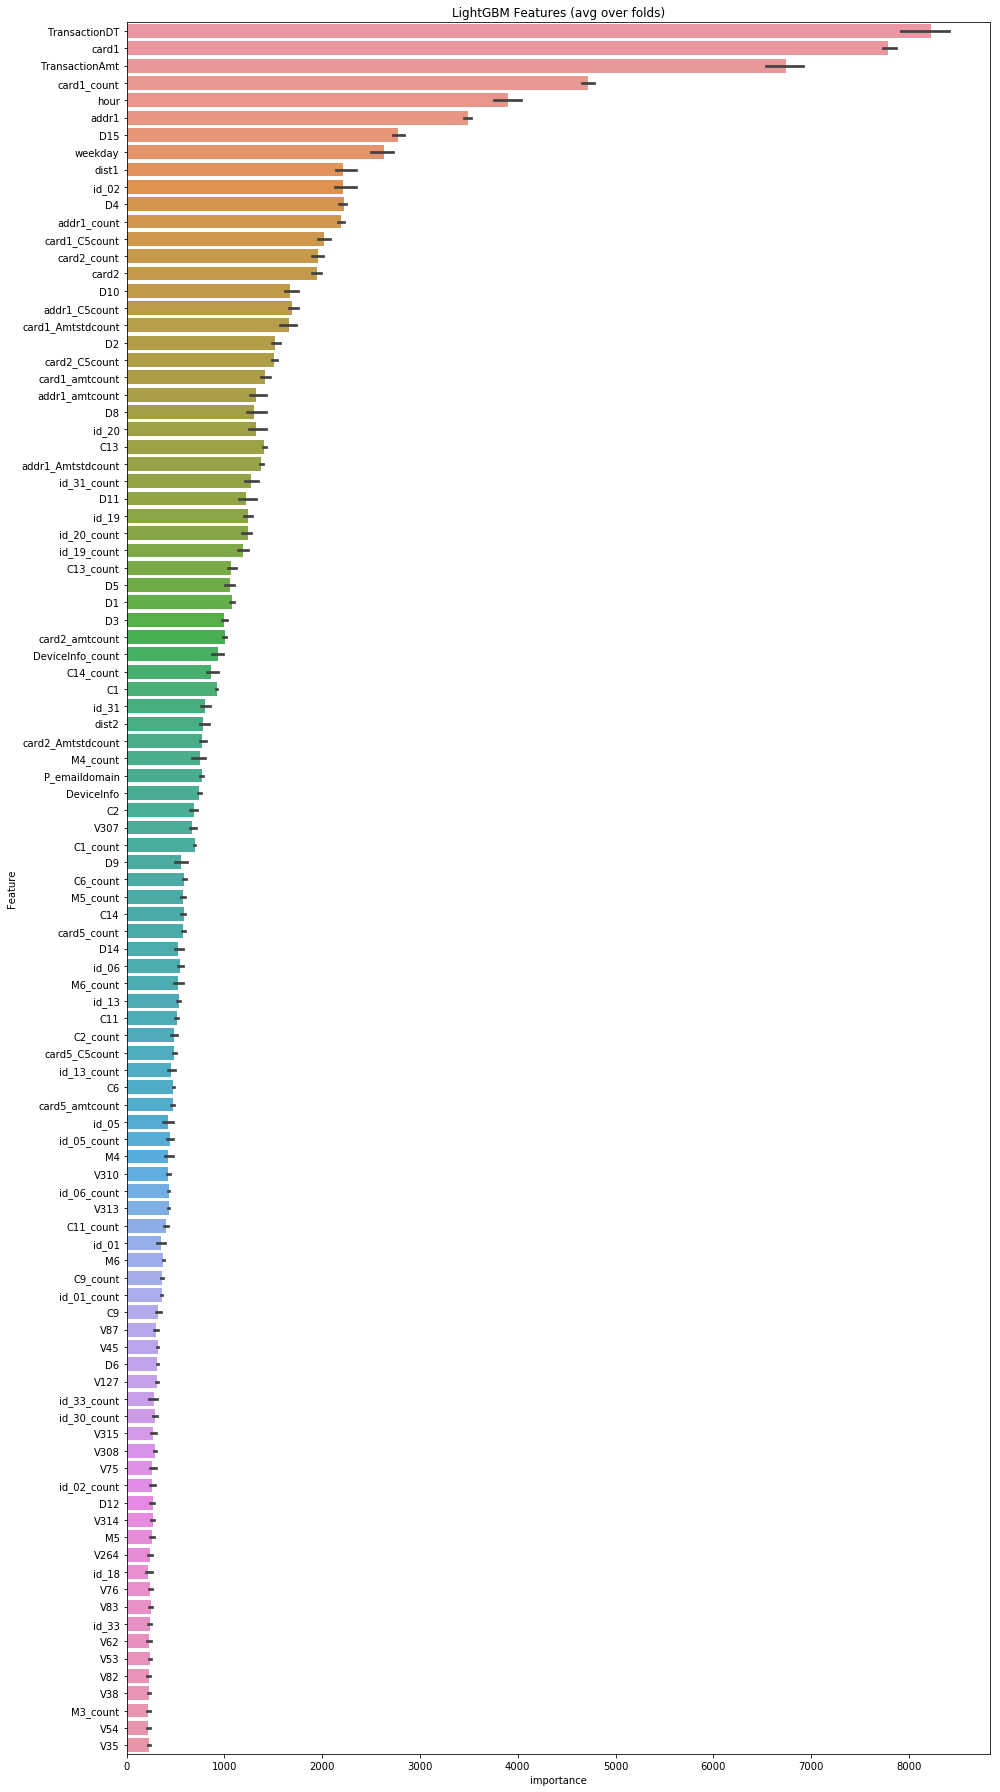

In [15]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
import catboost as cb
from catboost import CatBoostClassifier,Pool


features = [x for x in X_train.columns]

cate = [x for x in X_train.columns if (x == 'ProductCD' or x in ['card1','card2'] or x.startswith("addr") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" ]

# cate = []
print(cate)
verbose_eval = 30
num_rounds = 800

folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
y_preds3 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :].fillna(-1), X_train[features].iloc[val_idx, :].fillna(-1)
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    model=cb.CatBoostClassifier(iterations=num_rounds,depth=14,learning_rate=0.04,loss_function='Logloss',eval_metric='Logloss'
                                ,task_type = "GPU",devices = ["3"])
    if debug:
        model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_test[features].fillna(-1), y_test),verbose_eval = 30)
    else:
        model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_vl[features], y_vl),verbose_eval = 30)
        
    y_pred_train = model.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds3+= model.predict_proba(X_test[features].fillna(-1))[:,1] / folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict_proba(X_test[features].fillna(-1))[:,1] / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33))

['ProductCD', 'card1', 'card2', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']
0:	learn: 0.6166054	test: 0.6175160	best: 0.6175160 (0)	total: 760ms	remaining: 10m 7s
30:	learn: 0.0918790	test: 0.1083817	best: 0.1083817 (30)	total: 21.6s	remaining: 8m 56s
60:	learn: 0.0668519	test: 0.0908546	best: 0.0908546 (60)	total: 42.9s	remaining: 8m 39s
90:	learn: 0.0572777	test: 0.0874636	best: 0.0874636 (90)	total: 1m 4s	remaining: 8m 24s
120:	learn: 0.0524221	test: 0.0859159	best: 0.0859159 (120)	total: 1m 26s	remaining: 8m 4s
150:	learn: 0.0497623	test: 0.0849860	best: 0.0849860 (150)	total: 1m 47s	remaining: 7m 42s
180:	learn: 0.0476659	test: 0.0844377	best: 0.0844377 (180)	total: 2m 8s	remaining: 7m 20s
210:	learn: 0.0462063	test: 0.0842056	best: 0.0842019 (208)	total: 2m 29s	remaining: 6m 57s
240:	learn: 0.0446954	test: 0.0836868	best: 0.0836868 (240)	total: 2m 50s	remaining: 6m 35s
270:	learn: 0.0432764	test: 0.0834173	best: 0.0834173 (270)	total: 3m 11s	re

In [ ]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))
    print("debug:",roc_auc_score(y_test, y_preds2))
    print("debug:",roc_auc_score(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)*0.33))

In [38]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))
    print("debug:",roc_auc_score(y_test, y_preds2))
    print("debug:",roc_auc_score(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)*0.33))
    

debug: 0.9311505374220808
debug: 0.9247145911807212
debug: 0.9208217173120362
debug: 0.9354568339695938
debug: 0.9390082070823886
debug: 0.9391136216557666


In [39]:

sample_submission['isFraud'] = (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)*0.33
sample_submission.to_csv('simple_ensemble6.csv')


ValueError: Length of values does not match length of index